In [26]:
%reload_ext autoreload
%autoreload 2

In [1]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [3]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Loading  Data

In [4]:
from src.loader import SlackDataLoader

# Initialize DataLoader
data_loader = SlackDataLoader(rpath+'/data/anonymized')

# Load data from a Slack channel
channels = data_loader.get_channels()
users = data_loader.get_users()
userNamesById, userIdsByName = data_loader.get_user_map()
channelNamesById, channelIdsByName = data_loader.get_channel_map()
all_channels_slack_data = {}
all_channels_slack_reactions = {}
for channel in channels:
    ch_path = rpath+'/data/anonymized/'+channel["name"]+'/'
    all_channels_slack_reactions[channel["id"]] = data_loader.parse_slack_reaction(ch_path, channel["name"])
    all_channels_slack_data[channel["id"]] = data_loader.slack_parser(ch_path)

In [5]:
[df.head() for df in all_channels_slack_data.values()]

[  msg_type                                        msg_content     sender_name  \
 0  message                                       Morning boss   Travis Butler   
 1  message  You can find the updated list of the hot seate...   Travis Butler   
 2  message  *community Building Session REMINDER!*:timer_c...  Vanessa Norman   
 3  message                                              Hello    Daniel Brown   
 4  message                                              Selam  Miguel Herring   
 
    msg_sent_time msg_dist_type  time_thread_start  reply_count  \
 0   1.666941e+09          text                0.0            0   
 1   1.666948e+09          text                0.0            0   
 2   1.666958e+09          text                0.0            0   
 3   1.666958e+09          text                0.0            0   
 4   1.666958e+09          text                0.0            0   
 
    reply_users_count reply_users tm_thread_end channel  
 0                  0           0           

In [6]:
channels[0].keys()

dict_keys(['id', 'name', 'created', 'creator', 'is_archived', 'is_general', 'members', 'topic', 'purpose'])

## Task-1

In [7]:
#Top users & msgs in the most active channel
#find the active channel
print("The most active channel is all-community-building with 7613 messages, lets use that\n")

#Who are the top and bottom 10 users for the most active channel?
slack_data = all_channels_slack_data[channelIdsByName["all-community-building"]]
#by Reply count?
top_10_usrs_by_rpl_count = slack_data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:10]
botom_10_usrs_by_rpl_count = slack_data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=True)[:10]
print("Top 10 by mean reply count:\n {}\n".format(top_10_usrs_by_rpl_count))
print("Bottom 10 by mean reply count:\n {}\n".format(botom_10_usrs_by_rpl_count))

#by Mention(having most replier to them)?
top_10_usrs_by_mention_count = slack_data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:10]
botom_10_usrs_by_mention_count = slack_data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=True)[:10]
print("Top 10 by mean mentions count:\n {}\n".format(top_10_usrs_by_mention_count))
print("Bottom 10 by mean mentions count:\n {}\n".format(botom_10_usrs_by_mention_count))

#by Message count?
top_10_usrs_by_msg_count = slack_data['sender_name'].value_counts()[:10]
botom_10_usrs_by_msg_count = slack_data['sender_name'].value_counts()[-10:]
print("Top 10 by message count:\n {}\n".format(top_10_usrs_by_msg_count))
print("Bottom 10 by message count:\n {}\n".format(botom_10_usrs_by_msg_count))

#by Reaction count?
top_10_usrs_by_react = slack_data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum().sort_values(by='reply_count',ascending=False)[:10]
botom_10_usrs_by_react = slack_data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum().sort_values(by='reply_count',ascending=True)[:10]
print("Top 10 by reaction:\n {}\n".format(top_10_usrs_by_react))
print("Bottom 10 by reaction:\n {}\n".format(botom_10_usrs_by_react))

The most active channel is all-community-building with 7613 messages, lets use that

Top 10 by mean reply count:
 sender_name
Steven Garcia       5.333333
Brian Odom          1.139013
Carlos Gross        0.842857
Melissa Ingram      0.833333
Gary Thomas         0.787879
Carol Kaiser        0.765957
Vernon Garcia       0.666667
Katherine Foster    0.639535
Anita Rodriguez     0.612903
Samuel King         0.547945
Name: reply_count, dtype: float64

Bottom 10 by mean reply count:
 sender_name
Allison Thompson     0.000000
Slackbot             0.000000
Michele Sparks       0.000000
Mark Crawford        0.000000
Blake Scott          0.000000
Erica Munoz          0.000000
Christopher Case     0.000000
Nicholas Friedman    0.142012
Cheryl Hudson        0.166667
Joseph Diaz          0.188679
Name: reply_count, dtype: float64

Top 10 by mean mentions count:
 sender_name
Melissa Ingram      0.833333
Steven Garcia       0.750000
Vernon Garcia       0.666667
Carol Kaiser        0.574468
Carlos Gro

In [8]:
#What are the top 10 messages by, Assuming messages are repeated throughout the channel 
#by Reply count?
top_10_msgs_by_rpl_count = slack_data.groupby('msg_content')['reply_count'].mean().sort_values(ascending=False)[:10]
botom_10_msgs_by_rpl_count = slack_data.groupby('msg_content')['reply_count'].mean().sort_values(ascending=True)[:10]
print("Top 10 messages by mean reply count:\n {}\n".format(top_10_msgs_by_rpl_count))
print("Bottom 10 messages by mean reply count:\n {}\n".format(botom_10_msgs_by_rpl_count))

#by Mention(having most replier to them)?
top_10_msgs_by_mention_count = slack_data.groupby('msg_content')['reply_users_count'].mean().sort_values(ascending=False)[:10]
botom_10_msgs_by_mention_count = slack_data.groupby('msg_content')['reply_users_count'].mean().sort_values(ascending=True)[:10]
print("Top 10 messages by mean mentions count:\n {}\n".format(top_10_msgs_by_mention_count))
print("Bottom 10 messages by mean mentions count:\n {}\n".format(botom_10_msgs_by_mention_count))

#by Reaction count?
top_10_msgs_by_react = slack_data.groupby('msg_content')[['reply_count', 'reply_users_count']].sum().sort_values(by='reply_count',ascending=False)[:10]
botom_10_msgs_by_react = slack_data.groupby('msg_content')[['reply_count', 'reply_users_count']].sum().sort_values(by='reply_count',ascending=True)[:10]
print("Top 10 messages by reaction:\n {}\n".format(top_10_msgs_by_react))
print("Bottom 10 messages by reaction:\n {}\n".format(botom_10_msgs_by_react))

Top 10 messages by mean reply count:
 msg_content
<@U03V1AM5TFA> how many crushes you have?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   75.0
First Impression: People think I am older than I am,\nWhy: My hairline                                                                                                                                               

In [9]:
#Top & Bottom mentions for a channel(choosen by random)
mention_list = utils.get_tagged_users(all_channels_slack_data[channels[random.randint(0, len(channels))]["id"]])
flattened_mentions = [item for sublist in mention_list.to_list() if sublist != [] for item in sublist]
usr_mentions_count = dict(Counter(flattened_mentions))

In [10]:
#Top & Bottom 10 users by mention
print("Top 10 Users by mentions(Tags) count:\n {}\n".format(sorted(usr_mentions_count.items(), key=lambda x:x[1], reverse=True)[:10]))
print("Bottom 10 Users by mentions(Tags) count:\n {}\n".format(sorted(usr_mentions_count.items(), key=lambda x:x[1], reverse=False)[:10]))

Top 10 Users by mentions(Tags) count:
 [('@U03UG1RTXAP', 2), ('@U03U9EJR362', 1), ('@U03V61VGQG0', 1)]

Bottom 10 Users by mentions(Tags) count:
 [('@U03U9EJR362', 1), ('@U03V61VGQG0', 1), ('@U03UG1RTXAP', 2)]



In [11]:
#Which channel has the highest activity? 
#By counting total number of messages(rows in the dataframe)
top10channels = sorted([(k,v.shape[0]) for (k,v) in all_channels_slack_data.items()], key=lambda x:x[1], reverse=True)[:10]
for ch_id, no_msgs in top10channels:
    print(">> {} with {} messages\n".format(channelNamesById[ch_id], no_msgs))

>> all-community-building with 7613 messages

>> all-resources with 1464 messages

>> kafka_de with 898 messages

>> all-career-exercises with 782 messages

>> random with 581 messages

>> adludios-challange with 574 messages

>> all-week1 with 551 messages

>> ab_test-group with 546 messages

>> all-broadcast with 537 messages

>> all-week7 with 456 messages



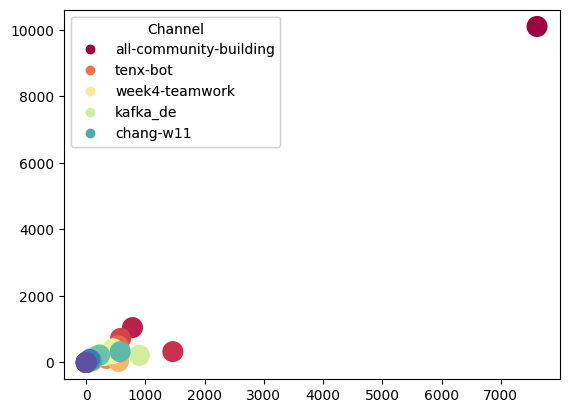

In [12]:
#Which channel appears at the right top corner when you plot a 2D scatter plot where 
#x-axis is the number of messages in the channel, y-axis is the sum of number of replies and reactions, 
#and the color representing channels?
fig, ax = plt.subplots()
scatter = ax.scatter([df.shape[0] for df in all_channels_slack_data.values()], 
            [sum(x) for x in zip([sum(df.loc[:,'reaction_count']) for df in all_channels_slack_reactions.values()], 
                                 [sum(df.loc[:,'reply_count']) for df in all_channels_slack_data.values()])], 
                                 s=200, c=range(len(channels)), cmap="Spectral")
handles, labels = scatter.legend_elements(num=5)
legend1 = ax.legend(handles, [channelNamesById[list(all_channels_slack_data.keys())[i*8]] for i in range(5)], loc="upper left", title="Channel") # type: ignore
ax.add_artist(legend1)

In [21]:
#What fraction of messages are replied within the first 5mins?
ontime_reply_rates = {}
total_rpl = 0
total_msgs = 0
max = 0
max_ch = ""
all_reply_gaps = {}
for ch_id, ch_data in all_channels_slack_data.items():
    replied_msgs = ch_data[ch_data['time_thread_start'] != 0]
    reply_gaps = {}
    ontime_rpls = 0
    for (x,y) in list(zip(replied_msgs.loc[:,'time_thread_start'], replied_msgs.loc[:,'msg_sent_time'])):
        reply_gaps[x] = y-x
        if reply_gaps[x] < 300:
            ontime_rpls += 1
    all_reply_gaps[ch_id] = reply_gaps
    #total_rlp_gaps[ch_id] = sum(reply_gap)
    #mean_rpl_gaps[ch_id] = total_rlp_gaps[ch_id]/len(reply_gap)
    if ontime_rpls:
        ontime_reply_rates[ch_id] = 100*ontime_rpls/ch_data.shape[0]
        if max < ontime_reply_rates[ch_id]:
            max = ontime_reply_rates[ch_id]
            max_ch = channelNamesById[ch_id]
        total_rpl += ontime_rpls
        total_msgs += ch_data.shape[0]
        print("channel {} has reply rate of {:.4f}% \n".format(channelNamesById[ch_id], ontime_reply_rates[ch_id]))
if total_rpl:
    print("All in all {:.4f}% of messages get replied within 5 mins".format(100*total_rpl/total_msgs))
    print("{} channel has the highst reply rate of {:.4f}% within 5 mins".format(max_ch, max))

channel all-community-building has reply rate of 38.9334% 

channel all-technical-support has reply rate of 38.8060% 

channel all-career-exercises has reply rate of 29.0281% 

channel all-resources has reply rate of 3.6885% 

channel random has reply rate of 14.8021% 

channel all-ideas has reply rate of 15.8103% 

channel all-week1 has reply rate of 37.2051% 

channel all-broadcast has reply rate of 9.1248% 

channel team-10 has reply rate of 25.9475% 

channel all-week2 has reply rate of 23.5075% 

channel ab_test-group has reply rate of 2.7473% 

channel week-2-group-8 has reply rate of 4.1667% 

channel dsa-sql has reply rate of 15.3846% 

channel all-week3 has reply rate of 31.5245% 

channel week4-teamwork has reply rate of 1.2346% 

channel study-group has reply rate of 2.3810% 

channel happy-new-year-study-group has reply rate of 5.3763% 

channel all-week4 has reply rate of 28.2759% 

channel all-week5 has reply rate of 20.4900% 

channel all-week6 has reply rate of 19.2691%

In [22]:
# which user has the highest number of reply counts?
top_usrs_by_rpl_count = all_channels_slack_data[channelIdsByName["all-week1"]].groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)[:5]
print("Top user by reply count in all-week1 channel is {}\n".format(top_usrs_by_rpl_count))

Top user by reply count in all-week1 channel is sender_name
Cristian Wilson     76
Michelle Lewis      60
Veronica Padilla    37
Brenda Hernandez    34
Katie Dickerson     24
Name: reply_count, dtype: int64



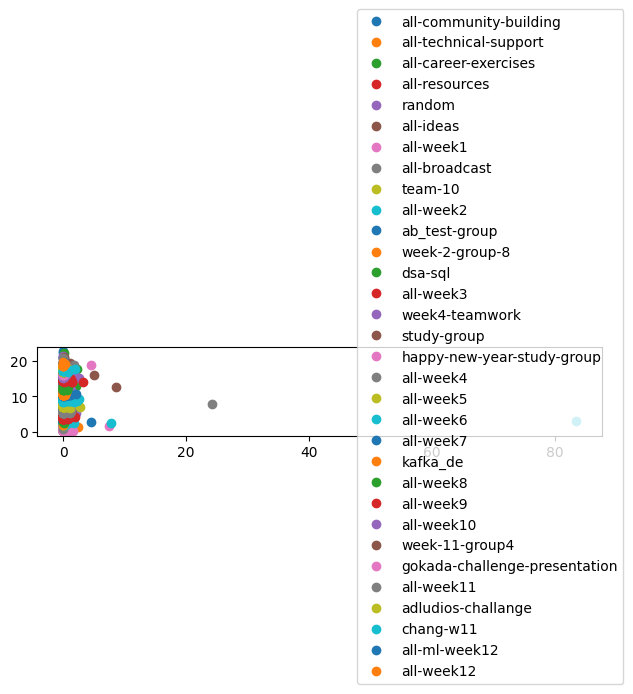

In [65]:
#Plot a 2D scatter plot such that x-axis is the time difference between the message timestamp and the first reply message, 
#y-axis is the time of the day (in 24hr format), color representing channels?
x,y,z = [],[],[]
for ch_id, gaps in all_reply_gaps.items():
    for t, gap in gaps.items():
        x.append(gap/50000)
        y.append(t/360000)
        z.append(ch_id)
Ys = [Y - min(y) for Y in y]
df = pd.DataFrame({'x': x,'y':Ys,'z':z})
groups = df.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, label=name)
plt.legend([channelNamesById[g[0]] for g in groups][0::4], bbox_to_anchor=(1.05, 1.0),loc='right')
plt.tight_layout()
plt.show()

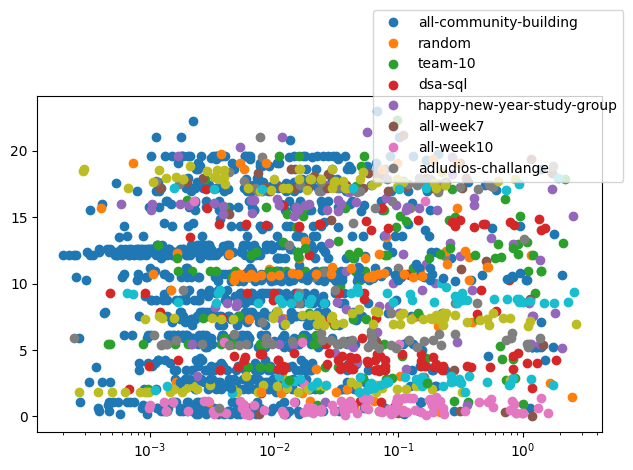

In [74]:
#log scale
plt.xscale("log")
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6)
plt.legend([channelNamesById[g[0]] for g in groups][0::4], bbox_to_anchor=(1.05, 1.0), loc='right')
plt.tight_layout()
plt.show()

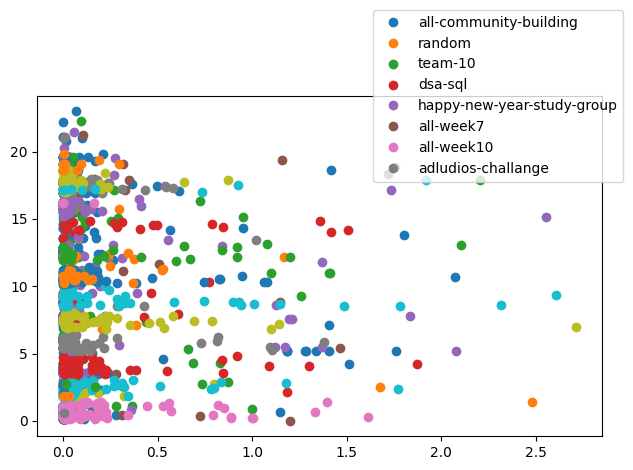

In [73]:
#removing the outliers, fastest replies
#sort the df by x(reply gap) & drop the bottom 10
df_new = df.query('x < 3')
groups = df_new.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6)

plt.legend([channelNamesById[g[0]] for g in groups][0::4], bbox_to_anchor=(1.05, 1.0),loc='right')
plt.tight_layout()
plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

#

In [14]:
# Visualize reply counts per user per channel

In [15]:
# what is the time range of the day that most messages are sent?


In [16]:
# what kind of messages are replied faster than others?

In [17]:
# Relationship between # of messages and # of reactions

In [18]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [19]:
# Which users got the most reactions?

In [20]:
# Model topics mentioned in the channel

In [21]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [22]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?